<a href="https://colab.research.google.com/github/HaSSSTI/Numpyro-with-MCMC-and-JAX/blob/main/v_0_3_wavelet_source_rec_L1_L2_HS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# priror is not negetive

In [ ]:
!pip install lenstronomy --quiet
!pip install jaxopt --quiet
!pip install gdown --quiet
!pip install numpyro --quiet
!pip install git+https://github.com/austinpeel/herculens.git --quiet
!pip install git+https://github.com/aymgal/utax.git@main --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
import argparse
import os
import time

import numpy as np
from scipy.special import expit

import jax.numpy as jnp
import jax.random as random
import jax

RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
import os
import numpy as np
from scipy import sparse, ndimage
import imageio as iio
from skimage.transform import resize

# from cr.sparse import lop
import matplotlib.pyplot as plt
# !pip install cr-sparse
!pip install gdown --quiet
import gdown
!pip install numpyro --quiet

from jax.scipy.optimize import minimize
import numpyro
from numpyro.diagnostics import summary
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
from numpyro.primitives import sample

from jax.experimental import sparse as jsparse
from lenstronomy.LightModel.Profiles.starlets import SLIT_Starlets

In [ ]:
#parameters
global n_scales
global n_pixels
global noisy_data
global reg_func
global sigma_noise
sigma_noise = 0.1
n_pixels=100
n_data_pixel_side = 200

In [ ]:
# https://drive.google.com/file/d/15AUlevQVEM60z1OfL0B2FPJYsQ7pV2vu/view?usp=share_link
# https://drive.google.com/file/d/1pVTEMDj2aKdF-QctpuC8bcXmD9IoSowl/view?usp=share_link
def download_data():
  id1 = "15AUlevQVEM60z1OfL0B2FPJYsQ7pV2vu"
  id2 = "1pVTEMDj2aKdF-QctpuC8bcXmD9IoSowl"
  id3 = "1ZJXwjzxJtk-4PwPGogKKyVWqoPwYOcM0"
  url = "https://drive.google.com/uc?id="+id1
  output = 'L.txt'
  gdown.download(url, output, quiet=False)
  url = "https://drive.google.com/uc?id="+id2
  output = 'NGC.jpg'
  gdown.download(url, output, quiet=False)
  url = "https://drive.google.com/uc?id="+id3
  output = 'jamesweb.jpg'
  gdown.download(url, output, quiet=False)

download_data()

Downloading...
From: https://drive.google.com/uc?id=15AUlevQVEM60z1OfL0B2FPJYsQ7pV2vu
To: /content/L.txt
100%|██████████| 889k/889k [00:00<00:00, 90.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pVTEMDj2aKdF-QctpuC8bcXmD9IoSowl
To: /content/NGC.jpg
100%|██████████| 1.79M/1.79M [00:00<00:00, 105MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZJXwjzxJtk-4PwPGogKKyVWqoPwYOcM0
To: /content/jamesweb.jpg
100%|██████████| 12.0k/12.0k [00:00<00:00, 18.1MB/s]


In [ ]:
# reads a sparse lensing matrix L from the file and constructs it as "Lensing_operator"
# so now to lens an image we need to do Lensing_operator @ S
def produce_lensing_matrix():
  x = np.fromfile("L.txt",sep=" ").reshape(-1,3)
  Row=x[:, 0]
  int_row = Row.astype(int)
  Column=x[:,1]
  int_Column = Column.astype(int)
  Data=x[:,2]
  L = sparse.coo_matrix((Data,(int_row,int_Column)),(int_row.max()+1,40000))
  L = L.transpose()
  L = jsparse.coo.coo_fromdense(jnp.array(L.todense()))
  return L

Lensing_operator = produce_lensing_matrix()

# model used to produce the mock observations (without noise)
def produce_simulated_observation(x):
  D = Lensing_operator @ x
  return D

# forward model for fitting: first construct a source image from its wavelet coefficients, then lens it with Lensing_operator
def forward_model(x):
  source = numpyro.deterministic('wavelet_transform',(starlet_profile._reconstruct_2nd_gen(x.reshape((n_scales+1,n_pixels,n_pixels))).reshape(n_pixels*n_pixels,1)))
  D = Lensing_operator @ source
  return D

# pick a background source, lens it, and add noise to produce a simulated noisy data
def prepare_data():

    img = iio.imread("NGC.jpg")
    img  =  img.mean(axis=2)
    np_img = np.array(img)
    img = resize(img, (100, 100))
    length = np.prod(img.shape)
    x_true = img.reshape((length,1))
    x_true = x_true / np.max(x_true)

    D = produce_simulated_observation(x_true)
    noisy_data = D + np.random.randn(*D.shape)*sigma_noise


    return x_true, noisy_data

In [ ]:
from utax.wavelet import WaveletTransform
n_scales=4
starlet_profile = WaveletTransform(n_scales)
SLIT = SLIT_Starlets(thread_count=8, fast_inverse=True, second_gen=True)

/usr/local/lib/python3.10/dist-packages/lenstronomy/LightModel/Profiles/starlets.py:42: UserWarning: The python package pySAP is not used for starlet operations. They will be performed using (slower) python routines.
  warnings.warn("The python package pySAP is not used for starlet operations. "


In [ ]:
x_true, noisy_data = prepare_data()
# plt.imshow(noisy_data.reshape(200,200))

<ipython-input-5-35e2223dd258>:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = iio.imread("NGC.jpg")


In [ ]:
src_true_coeffs = SLIT.decomposition_2d(x_true.reshape(100,100), n_scales=n_scales+1)
rec_source = starlet_profile._reconstruct_2nd_gen(src_true_coeffs) # reconstruct the source again from coeeficients for sanity check

#plots

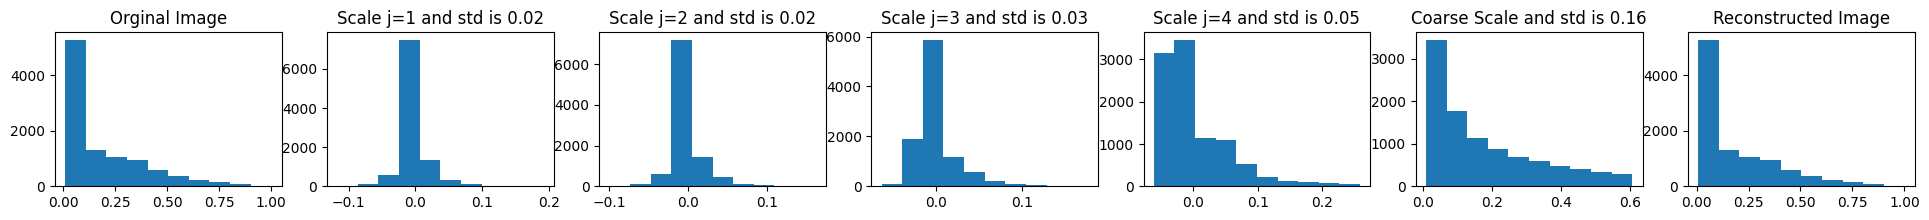

In [ ]:
fig, axes = plt.subplots(1,7, figsize=(24, 2))
for i, ax in enumerate(axes.flatten()):
  if i==0:
      im = ax.hist(x_true)
      ax.set_title(f"Orginal Image")
  elif i==6:
      im = ax.hist(rec_source.flatten())
      ax.set_title(f"Reconstructed Image")
  elif i==5:
    im = ax.hist(src_true_coeffs[i-1].flatten())
    ax.set_title(f"Coarse Scale and std is {round(np.std(src_true_coeffs[i-1].flatten()),2)}")
  else:
      im = ax.hist(src_true_coeffs[i-1].flatten())
      ax.set_title(f"Scale j={i} and std is {round(np.std(src_true_coeffs[i-1].flatten()),2)}")

  # ax.set_axis_off()
plt.savefig('fig_1.png')
plt.show()

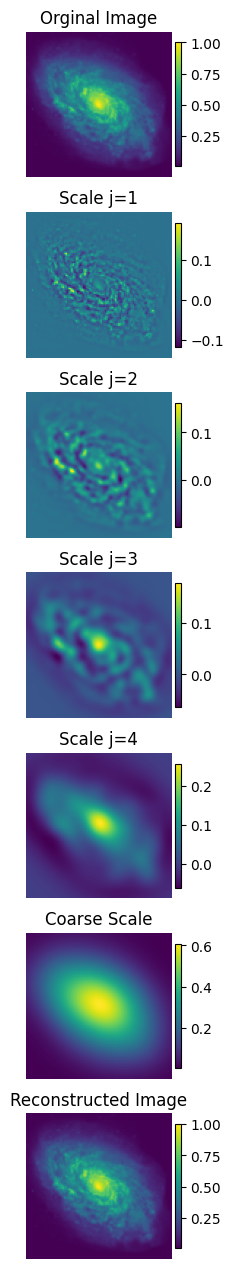

In [ ]:
fig, axes = plt.subplots(7, 1, figsize=(2, 16))
for i, ax in enumerate(axes.flatten()):
  if i==0:
      im = ax.imshow(x_true.reshape(100, 100))
      ax.set_title(f"Orginal Image")
  elif i==6:
      im = ax.imshow(rec_source)
      ax.set_title(f"Reconstructed Image")
  elif i==5:
    im = ax.imshow(src_true_coeffs[i-1].reshape(100, 100))
    ax.set_title(f"Coarse Scale")
  else:
      im = ax.imshow(src_true_coeffs[i-1].reshape(100, 100))
      ax.set_title(f"Scale j={i}")

  cbar = fig.colorbar(im, ax=ax, fraction=0.04, pad=0.02)
  ax.set_axis_off()
plt.savefig('fig_1.png')
plt.show()

In [ ]:

# draw from priors, choice are L1, L2, and L1.
# For now, let's just focus on L!

def draw_from_the_prior(prior = "L1"):
  if prior == "L1":
    # Here I'm experimenting with putting different levels of prior on the coefficients of different scales
    tensor_1 = jnp.ones((n_pixels, n_pixels)) * 0.2
    tensor_2 = jnp.ones((n_pixels, n_pixels)) * 0.5
    scale_tensor = jnp.stack([tensor_1, tensor_2, tensor_2, tensor_2, tensor_2], axis=0)

    x = numpyro.sample('wavelet_coeffs', dist.Laplace(loc=jnp.zeros((n_scales + 1, n_pixels, n_pixels)), scale=scale_tensor))
    # x = numpyro.sample('wavelet_coeffs', dist.Laplace(loc=jnp.zeros((n_scales+1, n_pixels, n_pixels)), scale=0.1))

  elif prior == "L1_nocoarse":
    # Here I'm experimenting with putting different levels of prior on the coefficients of different scales
    tensor_1 = jnp.ones((n_pixels, n_pixels)) * 0.2
    tensor_2 = jnp.ones((n_pixels, n_pixels)) * 0.5
    scale_tensor = jnp.stack([tensor_1, tensor_2, tensor_2, tensor_2], axis=0)

    x_coeffs = numpyro.sample('wavelet_coeffs', dist.Laplace(loc=jnp.zeros((n_scales, n_pixels, n_pixels)), scale=scale_tensor))
    x_coarse = numpyro.sample('wavelet_coarse', dist.Uniform(jnp.zeros((1, n_pixels, n_pixels)), 10.*jnp.ones((1, n_pixels, n_pixels))))
    x = jnp.concatenate([x_coeffs, x_coarse], axis=0)

  elif prior == "L2":
    tensor_1 = jnp.ones((n_pixels, n_pixels)) * 0.01
    tensor_2 = jnp.ones((n_pixels, n_pixels)) * 0.5
    scale_tensor = jnp.stack([tensor_1, tensor_1, tensor_2, tensor_2, tensor_2], axis=0)

    # x = numpyro.sample("x", dist.Normal(loc=jnp.zeros_like(x_true), scale=1.0))
    x = numpyro.sample('wavelet_coeffs', dist.Normal(loc=jnp.zeros((n_scales+1,n_pixels,n_pixels)), scale=scale_tensor))
  elif prior == "Horseshoe":
    alpha = 1
    Tau = 40.0 #numpyro.sample("tau", dist.HalfCauchy(jnp.ones(alpha)))
    with numpyro.plate('waveletJ', n_scales+1):
      with numpyro.plate('local_shrinkage', n_pixels*n_pixels):
        Lambda = numpyro.sample("lambdas", dist.HalfCauchy(scale=jnp.ones((1))))
        x = numpyro.sample('wavelet_coeffs', dist.Normal(loc=0, scale=Tau**2*Lambda**2))
  return x

# Draw from the prior, and then draw from the posterior.
# (the equvalanet of log posterior in normal non-probabilistic models)
def data_generating_model(noisy_data):
    x = draw_from_the_prior(prior = "L1")
    model_data = forward_model(x)
    numpyro.sample("obs", dist.Normal(model_data, sigma_noise), obs=noisy_data)

In [ ]:
#run MCMC
kernel = NUTS(data_generating_model)

mcmc = MCMC(
    kernel,
    num_warmup=40,
    num_samples=10,
    num_chains=1,
    progress_bar=True,
)

rng_key, rng_key_predict = random.split(random.PRNGKey(0))
mcmc.run(rng_key, noisy_data)


sample: 100%|██████████| 50/50 [00:32<00:00,  1.52it/s, 1023 steps of size 3.00e-03. acc. prob=0.81]


In [ ]:
samples = mcmc.get_samples()
summary_y = summary(samples, group_by_chain=False)
x_samples = samples["wavelet_transform"]
x_samples_np = np.array(x_samples)
variance_map = np.var(x_samples_np, axis=0)

#**Hasti's comparison**

In [ ]:
# regression model with continuous-valued outputs/responses
def model_L1_likelihood(Y):
    Tau = numpyro.sample("tau", dist.HalfCauchy(jnp.ones(1)))
    with numpyro.plate('wavelet', n_scales+1):
     with numpyro.plate('local_shrinkage', n_pixels*n_pixels):
       coeffs = numpyro.sample('wavelet_coeffs', dist.Laplace(loc=0, scale=0.05))
    s_found = numpyro.deterministic('wavelet_transform_',(starlet_profile._reconstruct_2nd_gen(jax.nn.relu(coeffs).reshape((n_pixels,n_pixels,n_scales+1)).transpose()).reshape(n_pixels*n_pixels,1)))
    # we try to see how setting images value to zero affect the result
    s_found = numpyro.deterministic('wavelet_transform',(s_found))
    # s_found= s_found.at[jnp.where(s_found<0)].set(0.00)
    mean_function = (Lensing_operator @ (s_found))
    numpyro.sample("Y", dist.Normal(mean_function, sigma_noise), obs=Y)

# let the coarse be bigger
def model_L1_likelihood_modified(Y):
    Tau = numpyro.sample("tau", dist.HalfCauchy(jnp.ones(1)))

    with numpyro.plate('wavelet', n_scales):
     with numpyro.plate('local_shrinkage', n_pixels*n_pixels):
       coeffs_non_coa = numpyro.sample('coeffs_non_coa', dist.Laplace(loc=0, scale=0.01))

    with numpyro.plate('wavelet', 1):
      with numpyro.plate('local_shrinkage', n_pixels*n_pixels):
        coeffs_coa = numpyro.sample('wavelet_coa', dist.Laplace(loc=0, scale=0.1))
    # print(coeffs_coa.shape)

    coeffs = jnp.concatenate((coeffs_non_coa,coeffs_coa),axis=1)
    # print(coeffs.shape)
    coeffs = numpyro.deterministic('wavelet_coeffs',(coeffs))

    s_found = numpyro.deterministic('wavelet_transform_',(starlet_profile._reconstruct_2nd_gen(jax.nn.relu(coeffs).reshape((n_pixels,n_pixels,n_scales+1)).transpose()).reshape(n_pixels*n_pixels,1)))
    # print(s_found.shape)

    # we try to see how setting images value to zero affect the result
    s_found = numpyro.deterministic('wavelet_transform',(s_found))
    # s_found= s_found.at[jnp.where(s_found<0)].set(0.00)
    mean_function = (Lensing_operator @ (s_found))
    numpyro.sample("Y", dist.Normal(mean_function, sigma_noise), obs=Y)

In [ ]:
#run MCMC
kernel_ = NUTS(model_L1_likelihood_modified)

mcmc_ = MCMC(
    kernel_,
    num_warmup=1000,
    num_samples=500,
    num_chains=1,
    progress_bar=True,
)

rng_key, rng_key_predict = random.split(random.PRNGKey(0))
mcmc_.run(rng_key, noisy_data)

sample: 100%|██████████| 1500/1500 [22:53<00:00,  1.09it/s, 1023 steps of size 2.52e-03. acc. prob=0.81]


In [ ]:
samples_ = mcmc_.get_samples()
summary_h = summary(samples_, group_by_chain=False)

s_found_h = summary_h['wavelet_transform']['mean']
print(np.var(s_found_h[:,0]))

x_samples_ = samples_["wavelet_transform"]
x_samples_np_ = np.array(x_samples_)
variance_map_ = np.var(x_samples_np_, axis=0)


NameError: ignored

scale = 0.1 : 0.026686825

---
scale = 1 : 0.04368033

---
scale = 0.01 + short run: 0.01095045

Mean squared error: h:  0.03193369848346316

ssim: h:  0.9979834773951334

noise variance: h:  0.01095045

---
scale = 0.01 + long run(400+1000):

Mean squared error: h:  0.03662558613436816

ssim: h:  0.9974315591341267

noise variance: h:  0.008426437

---
scale = 0.05 + run(400+100):

Mean squared error: h:  0.005747419587823306

ssim: h:  0.9998920058331005

noise variance: h:  0.022066578

---

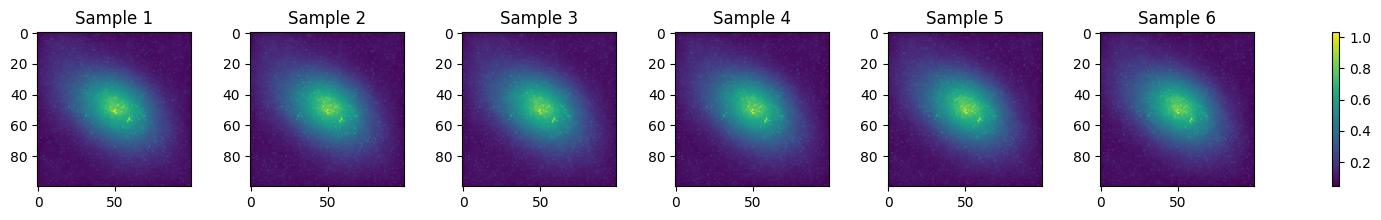

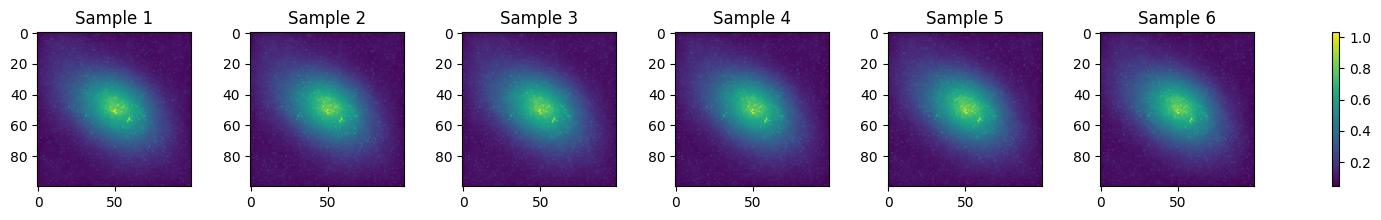

In [ ]:
fig, axes = plt.subplots(1, 6, figsize=(20, 2))

for i, ax in enumerate(axes.flatten()):
  # vmin, vmax = -1,2
  im = ax.imshow(x_samples_np_[i].reshape(100, 100))
  ax.set_title(f"Sample {i + 1}")
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

fig, axes = plt.subplots(1, 6, figsize=(20, 2))
x_samples_np_z = x_samples_np_
x_samples_np_z[x_samples_np_<0]=0
for i, ax in enumerate(axes.flatten()):
  # vmin, vmax = -1,2
  im = ax.imshow(x_samples_np_z[i].reshape(100, 100))
  ax.set_title(f"Sample {i + 1}")
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

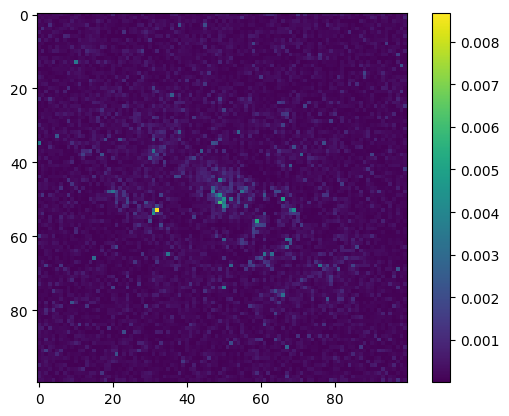

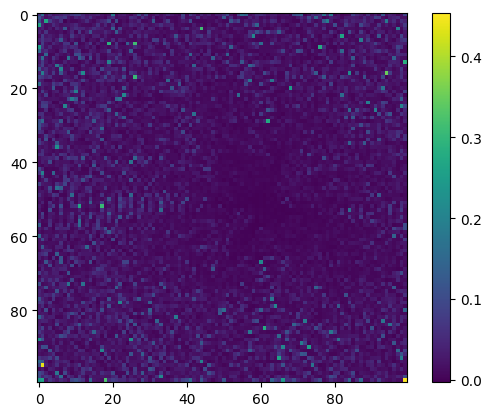

In [ ]:
plt.imshow((variance_map_).reshape(100,100))
plt.colorbar()
plt.show()
plt.imshow((variance_map-variance_map_).reshape(100,100))
plt.colorbar()
plt.show()

In [ ]:
# plt.scatter(variance_map_,s_found_h.reshape(-1)-x_true.reshape(-1))

In [ ]:
def mse(x,y):
    mse = np.mean((x-y)**2)
    return mse


def ssim(a, b, k1=0.01, k2=0.03, L=255):
    """
    Compute the Structural Similarity Index (SSIM) between two grayscale images.

    Parameters:
    a (ndarray): Pixel values of the first image.
    b (ndarray): Pixel values of the second image (same size as a).
    k1 (float): SSIM parameter controlling the impact of the luminance difference on the score.
    k2 (float): SSIM parameter controlling the impact of the contrast difference on the score.
    L (float): Maximum pixel value (usually 255 for 8-bit images).

    Returns:
    float: The SSIM score between a and b, ranging from -1 (completely dissimilar) to 1 (identical).
    """
    c1 = (k1 * L) ** 2
    c2 = (k2 * L) ** 2
    mu_a = np.mean(a)
    mu_b = np.mean(b)
    var_a = np.var(a)
    var_b = np.var(b)
    cov_ab = np.cov(a, b)[0][1]
    num = (2 * mu_a * mu_b + c1) * (2 * cov_ab + c2)
    den = (mu_a ** 2 + mu_b ** 2 + c1) * (var_a + var_b + c2)
    return num / den

def noise_estimation(x):
  return np.var(x[:,0])

In [ ]:
# s_found_y = summary_y['wavelet_transform']['mean']
s_found_h = summary_h['wavelet_transform']['mean']

# print("Mean squared error: y: ", mse(s_found_y,x_true))
# print("ssim: y: ", ssim(s_found_y.reshape(-1),x_true.reshape(-1)))
# print("noise variance: y: ", noise_estimation(s_found_y))

print("Mean squared error: h: ", mse(s_found_h,x_true))
print("ssim: h: ", ssim(s_found_h.reshape(-1),x_true.reshape(-1)))
print("noise variance: h: ", noise_estimation(s_found_h))
print('-----------------------')
print("noise variance: true: ", noise_estimation(x_true))

NameError: ignored

Text(0.5, 1.0, 'Distribution of Coeffs Yashar')

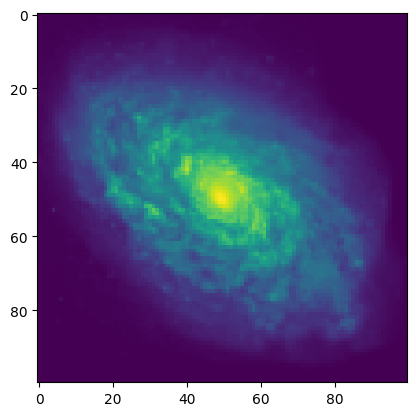

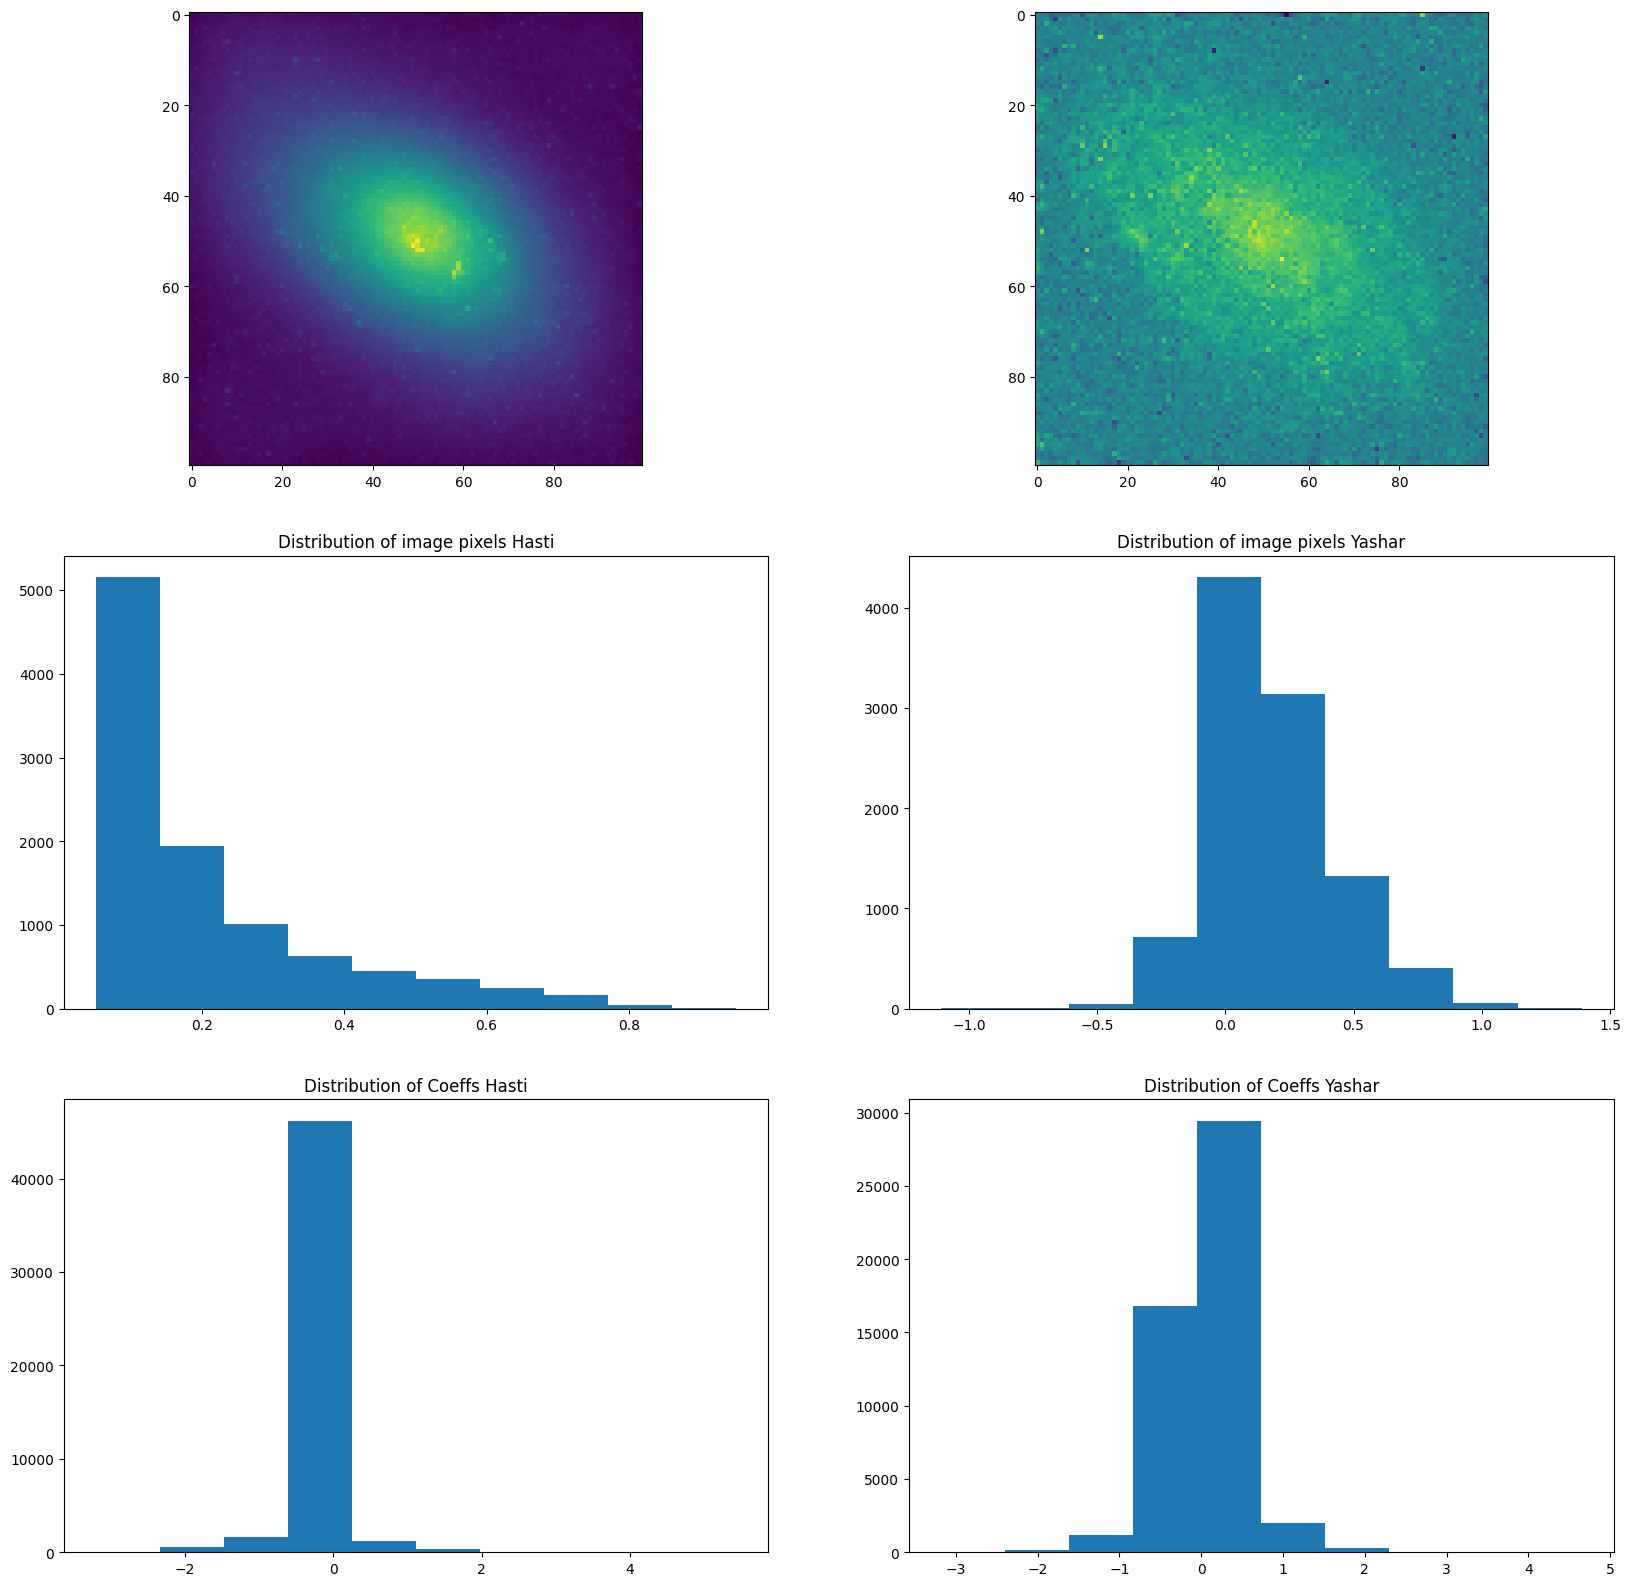

In [ ]:
plt.imshow(x_true.reshape(n_pixels,n_pixels))
plt.plot()
Name= "xxxxx"
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

axes[0,0].imshow(summary_h['wavelet_transform']['mean'].reshape(n_pixels,n_pixels))
# plt.title("Reconstruction with {}".format(Name + " & MCMC"))
# plt.colorbar()
# plt.show()

axes[0,1].imshow(summary_y['wavelet_transform']['mean'].reshape(n_pixels,n_pixels))
# plt.title("Reconstruction with {}".format(Name + " & MCMC"))
# plt.colorbar()
# plt.show()

# Distribution of s_found's pixels
axes[1,0].hist(summary_h['wavelet_transform']['mean'])
axes[1,0].set_title("Distribution of image pixels Hasti")
# plt.savefig("Distribution of s_found's pixels")
# plt.show()

axes[1,1].hist(summary_y['wavelet_transform']['mean'])
axes[1,1].set_title("Distribution of image pixels Yashar")
# plt.savefig("Distribution of s_found's pixels")
# plt.show()

#Distribution of Coeffs
axes[2,0].hist(summary_h['wavelet_coeffs']['mean'].flatten())
axes[2,0].set_title("Distribution of Coeffs Hasti")
# plt.savefig("Distribution of Coeffs")
# plt.show()

axes[2,1].hist(summary_y['wavelet_coeffs']['mean'].flatten())
axes[2,1].set_title("Distribution of Coeffs Yashar")
# plt.savefig("Distribution of Coeffs")
# plt.show()

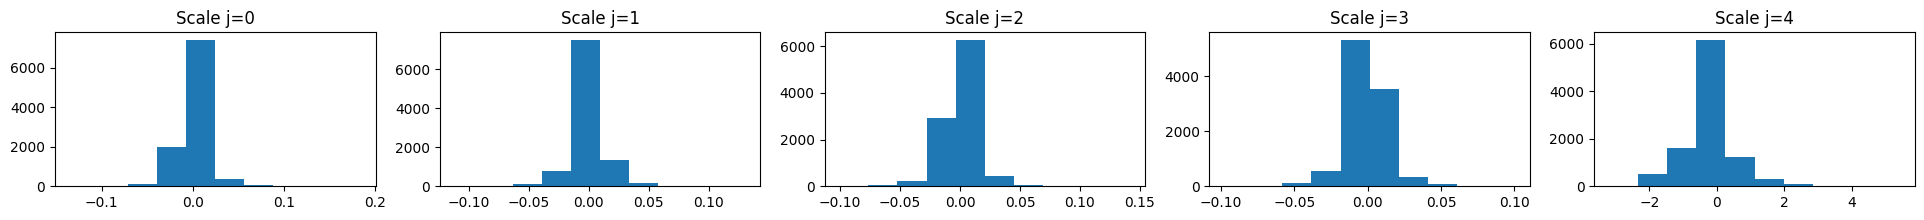

In [ ]:
fig, axes = plt.subplots(1,5, figsize=(24, 2))
for i, ax in enumerate(axes.flatten()):
    im = ax.hist(summary_h['wavelet_coeffs']['mean'][:,i])
    ax.set_title(f"Scale j={i}")

  # ax.set_axis_off()
# plt.savefig('fig_1.png')
plt.show()

#inspect 6 reconstructed source samples

TypeError: ignored

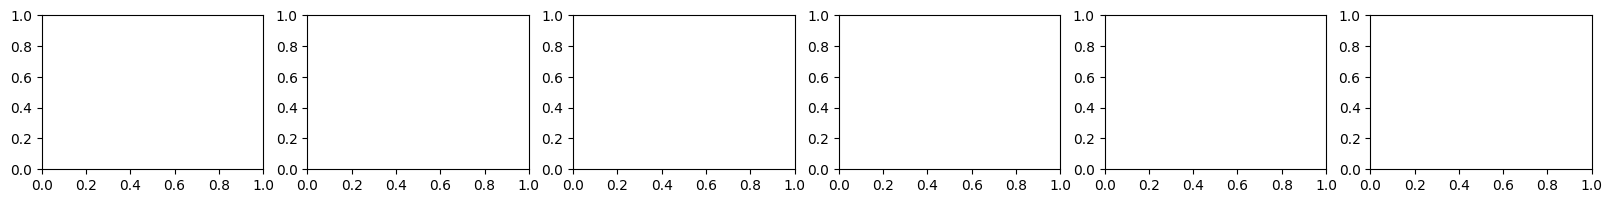

In [ ]:
fig, axes = plt.subplots(1, 6, figsize=(20, 2))

for i, ax in enumerate(axes.flatten()):
  # vmin, vmax = -1,2
  im = ax.imshow(x_samples[i].reshape(100, 100))
  ax.set_title(f"Sample {i + 1}")

fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

#inspect the per-pixel variance map in the source plane

---



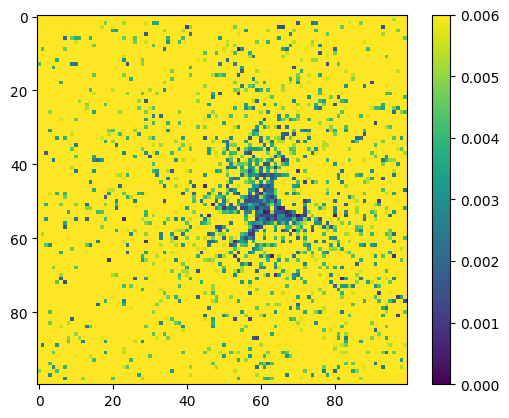

In [ ]:
plt.imshow(variance_map.reshape(100,100),vmin=0.,vmax=0.006)
plt.colorbar()

#inspect the lens-plane images and the residuals for 6 samples

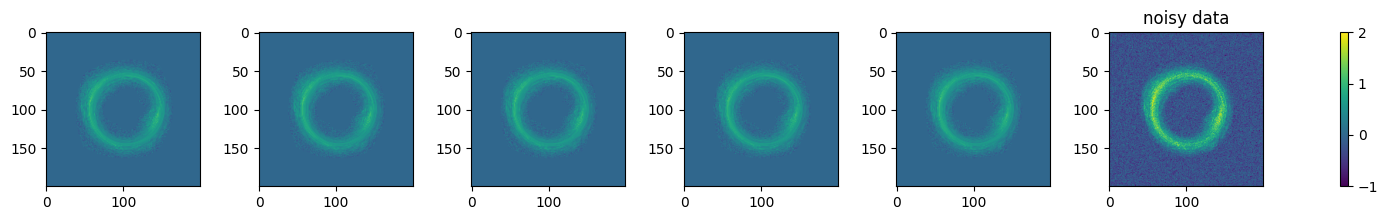

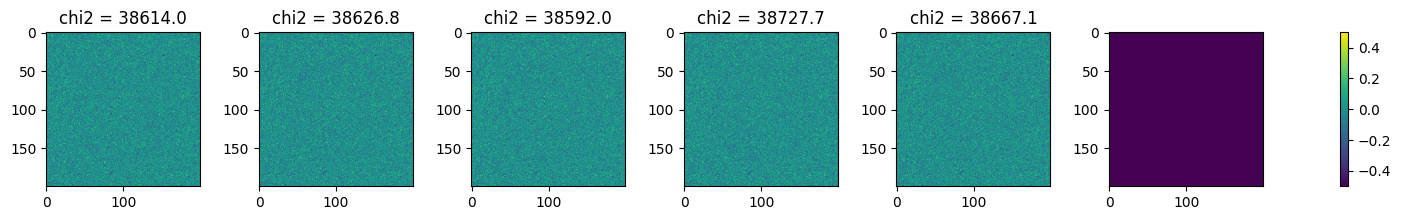

In [ ]:
coeff_samples = samples["wavelet_coeffs"]
if coeff_samples.shape[1] == n_scales:
    # add coarse scale to complete the wavelet set of scales
    coeff_samples = jnp.concatenate([coeff_samples, samples["wavelet_coarse"]], axis=1)

fig, axes = plt.subplots(1, 6, figsize=(20, 2))
for i, ax in enumerate(axes.flatten()[:5]):
  vmin, vmax = -1,2
  sky_model = forward_model(coeff_samples[i])
  im = ax.imshow(sky_model.reshape(200, 200), vmin=vmin, vmax=vmax)

ax_last = axes.flatten()[5]
ax_last.imshow(noisy_data.reshape(n_data_pixel_side,n_data_pixel_side))
ax_last.set_title(f"noisy data")

fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

fig, axes = plt.subplots(1, 6, figsize=(20, 2))
for i, ax in enumerate(axes.flatten()[:5]):
  vmin, vmax = -0.5,0.5
  sky_model = forward_model(coeff_samples[i])
  residuals = noisy_data.reshape(n_data_pixel_side,n_data_pixel_side) - sky_model.reshape(n_data_pixel_side, n_data_pixel_side)
  chi2 = np.sum(residuals**2/sigma_noise**2)
  im = ax.imshow(residuals, vmin=vmin, vmax=vmax)
  ax.set_title(f"chi2 = {chi2:.1f}")

ax_last = axes.flatten()[5]
ax_last.imshow(0.* noisy_data.reshape(n_data_pixel_side,n_data_pixel_side))

fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()



# Look at the contribution from different J scales for one sample

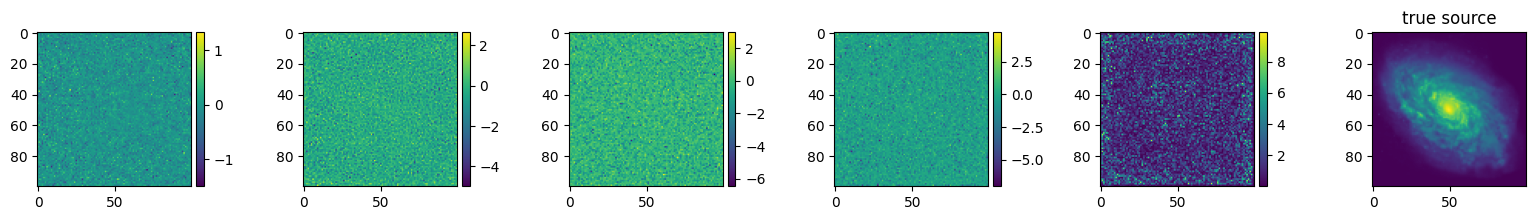

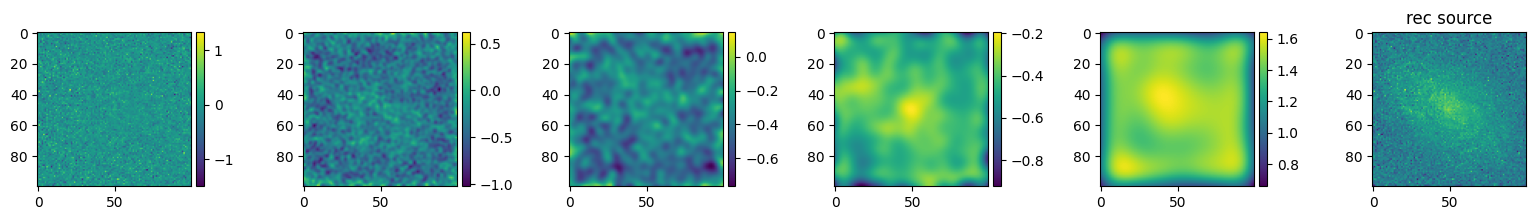

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from jax import lax

fig, axes = plt.subplots(1, 6, figsize=(20, 2))
for i, ax in enumerate(axes.flatten()[:5]):
  im = ax.imshow(coeff_samples[0][i,:,:])
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  fig.colorbar(im, cax=cax)

ax_last = axes.flatten()[5]
ax_last.imshow(coeff_samples[0][i,:,:]*0.)

ax_last = axes.flatten()[5]
ax_last.imshow(x_true.reshape(100,100))
ax_last.set_title(f"true source")


fig, axes = plt.subplots(1, 6, figsize=(20, 2))
index_list = [[1, 0, 0, 0, 0],[0, 1, 0, 0, 0],[0, 0, 1, 0, 0],[0, 0, 0, 1, 0],[0, 0, 0, 0, 1]]
total_image = 0.
for i, ax in enumerate(axes.flatten()[:5]):
  single_J_coeffs = coeff_samples[0]

  mask = jnp.array(index_list[i]).reshape(5, 1, 1)

  selected_coeff = mask * single_J_coeffs

  rec_source = starlet_profile._reconstruct_2nd_gen(selected_coeff)
  total_image = total_image + rec_source
  im = ax.imshow(rec_source)
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  fig.colorbar(im, cax=cax)

ax_last = axes.flatten()[5]
ax_last.imshow(total_image)
ax_last.set_title(f"rec source")

plt.show()




warmup=40 | L1_nocoarse
Mean squared error: y:  0.0174813741662424
ssim: y:  0.99967433311573
noise variance: y:  0.055326123

Mean squared error: h:  0.00799273004853795
ssim: h:  0.9998390213684923
noise variance: h:  0.042534705

noise variance: x_true:  0.03948696713590657
bold text
warmup=1000 for hasti | L1_nocoarse
Mean squared error: y:  0.0174813741662424
ssim: y:  0.99967433311573
noise variance: y:  0.055326123

Mean squared error: h:  0.007114912619835073
ssim: h:  0.9998543313717817
noise variance: h:  0.04181978


warmup=40 | L1 for y
Mean squared error: y:  0.013564778246929358
ssim: y:  0.9997687007170601
noise variance: y:  0.052751277

Mean squared error: h:  0.008206313284916686
ssim: h:  0.9998331901130106
noise variance: h:  0.04255915

warmup=40 | L1 for y | relu for setting s_found to zero for hasti
Mean squared error: y:  0.013564778246929358
ssim: y:  0.9997687007170601
noise variance: y:  0.052751277

Mean squared error: h:  0.004740192445465337
ssim: h:  0.9999123096472385
noise variance: h:  0.03679948
